In [1]:
%load_ext autoreload
%autoreload 2

import os

import pandas as pd
from pytorch_lightning import Trainer
from pl_module import CMPNNLitModel, MultiCMPNNLitModel
from dataset import CMPNNDataset, MultiCMPNNDataset, MultiCMPNNDatasetSDF, CMPNNDataModule
from preprocessing import scaffold_split_indices, random_split_indices
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.utils.data import Subset
from global_feat import CompositeGlobalFeaturizer, MorganBinaryFeaturizer, RDKit2DNormalizedFeaturizer

In [2]:
pd.read_csv("/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/target_data.csv").columns

Index(['rxn', 'r1_radius', 'r2_radius', 'alpha_angle', 'psi_1_dihedral',
       'psi_2_dihedral'],
      dtype='object')

In [3]:
root = "."
sdf_dir = "/home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/"
targets = "/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/target_data.csv"
target_cols  = ["psi_1_dihedral"]
target_types = {"psi_1_dihedral": "periodic"}



In [4]:

ds = MultiCMPNNDatasetSDF(
    root,
    sdf_files=sdf_dir,
    target_df=targets,
    target_cols=target_cols,
    target_types=target_types,
    atom_messages=True,
    keep_hs=True,
    sanitize=False,
    force_reload=True,
    prune_value=-10,
    global_featurizer= CompositeGlobalFeaturizer(
        featurizers=[
            MorganBinaryFeaturizer(radius=2, length=2048),
            RDKit2DNormalizedFeaturizer(),
        ]
    ),
    # pre_transform=PeriodicToSinCosGaussianJitter(target_cols, target_types, radians = False, ignore_val=-10, max_jitter_deg = 10)
)

Processing...
/home/calvin/code/vibe_cmpnn/dataset.py:514: UserWarning: No target row for reaction 'rxn_288' – skipped
  warnings.warn(f"No target row for reaction '{rxn}' – skipped")
/home/calvin/code/vibe_cmpnn/dataset.py:514: UserWarning: No target row for reaction 'rxn_635' – skipped
  warnings.warn(f"No target row for reaction '{rxn}' – skipped")
/home/calvin/code/vibe_cmpnn/dataset.py:514: UserWarning: No target row for reaction 'rxn_785' – skipped
  warnings.warn(f"No target row for reaction '{rxn}' – skipped")
Done!


In [5]:
ds.global_feature_dim

2248

In [6]:
# from my_transformer import PeriodicToSinCos, PeriodicToSinCosGaussianJitter
# dm = CMPNNDataModule(
#     root=root,
#     sdf_files=sdf_dir,
#     target_df=targets,
#     target_cols=target_cols,
#     target_types=target_types,
#     atom_messages=True,
#     keep_hs=True,
#     sanitize=False,
#     force_reload=True,
#     train_transform=PeriodicToSinCosGaussianJitter(target_cols, target_types, radians = False, ignore_val=-10, max_jitter_deg = 10),
#     val_transform=PeriodicToSinCos(target_cols, target_types, radians = False, ignore_value=-10),
#     test_transform=PeriodicToSinCos(target_cols, target_types, radians = False, ignore_value=-10),
#     batch_size=64,
#     splitter=lambda dataset: random_split_indices(dataset, 0.1, 0.1),
#     input_type=("r1h", "r2h"),
#     prune_value=-10
# )

In [7]:
# dm.setup()

In [8]:
train_idx, val_idx, test_idx = random_split_indices(ds, 0.1, 0.1)

print(f"train: {len(train_idx)}, val: {len(val_idx)}, test: {len(test_idx)}")

train: 1356, val: 170, test: 170


In [9]:
ds.compute_normalization(train_idx)


(tensor([]), tensor([]), tensor([-0.0850]))

In [10]:
ds.apply_normalization()

In [11]:
train_ds = Subset(ds, train_idx)
val_ds   = Subset(ds, val_idx)
test_ds  = Subset(ds, test_idx)

In [12]:
from utils_paired import collate_pairs
# Use pytorch pure data loader
from torch.utils.data import DataLoader
# 7) create dataloaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_pairs)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_pairs)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_pairs)

In [13]:
# train_full_ds = dm.train_dataset.dataset 

In [14]:
# dm.mean_dir

In [15]:
# train_full_ds.mean

In [16]:
# print(f"mean: {train_full_ds.mean}, std: {train_full_ds.std}")

In [17]:
# train_full_ds[0][0].y

# # Need to find a -10 in the y
# for i in range(len(train_full_ds)):
#     if (train_full_ds[i][0].y == -10).any():  # Check if any element in y equals -10
#         print(i)
#         break

In [18]:
# train_full_ds

In [19]:
# # pull one item *from* the train_dataset, not from train_dataset.dataset
# g1, g2 = dm.test_dataset[0]
# print("Transformed y for periodic head:", g1.y)
# # should be a 1×(C + 2P) Tensor, where the last 2P entries are sin/cos pairs


In [20]:
# from transformers import PeriodicToSinCos
# ds.transform = PeriodicToSinCos(
#     cont_idx = ds.cont_idx,
#     per_idx = ds.per_idx,
#     radians = False
# )

In [21]:
from utils_paired import collate_pairs
# Use pytorch pure data loader
from torch.utils.data import DataLoader
# 7) create dataloaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_pairs)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_pairs)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_pairs)
sample_pairs = [train_ds[i] for i in range(4)]   # 4 tuple-pairs
batch        = collate_pairs(sample_pairs)       # now returns one Batch
print(type(batch), batch.num_graphs)             # Batch 8

batch.num_graphs
batch.y

<class 'abc.DataBatch'> 8


tensor([[ 0.9131, -0.4077],
        [ 0.9131, -0.4077],
        [ 0.5224,  0.8527],
        [ 0.5224,  0.8527],
        [-0.1589,  0.9873],
        [-0.1589,  0.9873],
        [ 0.0844,  0.9964],
        [ 0.0844,  0.9964]])

In [22]:
for batch in train_loader:
    print(batch.y[0])
    break

tensor([-0.4202, -0.9074])


tensor([-0.4656,  0.8850])

In [23]:
# from sklearn.preprocessing import StandardScaler
# from my_transformer import ScaleTransform
# import numpy as np
# X_d_train = np.stack([
#     np.concatenate([
#         ds.pairs[i][0].global_features.numpy().squeeze(),
#         ds.pairs[i][1].global_features.numpy().squeeze()
#     ])
#     for i in train_idx
# ])
# scaler = StandardScaler().fit(X_d_train)
# X_d_transform = ScaleTransform.from_standard_scaler(scaler)

In [24]:
# X_d_transform

In [25]:
# # Pull out *all* targets from your full dataset
# import torch
# import math
# full_ds = dm.train_dataset.dataset  # the underlying MultiCMPNNDatasetSDF
# angles = full_ds.raw_y.squeeze(1)  # shape (N, 1)

# print("Angle range:", angles.min().item(), "to", angles.max().item())
# print("Std dev:", angles.std().item())


In [26]:
ds.num_targets

2

In [27]:
ds.mean

tensor([])

In [28]:
ds.global_feature_dim

2248

In [29]:
from torchmetrics import MeanSquaredError, MeanAbsoluteError, R2Score
# Check device
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [159]:
from metrics import MSE, RMSE, R2Score, MAE, AngularError, SinCosMSELoss, AngularMSELoss
print(">>> Model class created")
model = MultiCMPNNLitModel(
    in_node_feats=ds.num_atom_features,
    in_edge_feats=ds.num_bond_features,
    in_global_feats=ds.global_feature_dim,
    hidden_dim=1024,
    num_steps=3,
    dropout_mp=0.4,
    dropout_head=0.4,
    n_tasks=2,
    metrics=[AngularError()],
    #metrics=[MSE(), RMSE(), MAE()],
    lr=1e-4,
    weight_decay=1e-4,
    target_mean=ds.mean,
    target_std=ds.std,
    mpn_shared=True,
    target_types=target_types,
    # ignore_val=-10,
    jitter=False,
    normalize_head=True,
    readout="sum",
    X_d_transform=None,
    mean_dir=ds.per_mean_dir,
)
print(">>> Model instantiated")

>>> Model class created
>>> Model instantiated


In [160]:
gfs = torch.stack([ds.pairs[i][0].global_features for i in range(100)])
print(gfs.mean(dim=0))
print(gfs.std(dim=0))


tensor([[0.0000, 0.0100, 0.0000,  ..., 0.0769, 0.1750, 0.1938]])
tensor([[0.0000, 0.1000, 0.0000,  ..., 0.2619, 0.0833, 0.0824]])


In [161]:
def reset_model_weights(model):
    for module in model.modules():
        if hasattr(module, 'reset_parameters'):
            module.reset_parameters()

reset_model_weights(model)

In [162]:
# clear cuda cache
torch.cuda.empty_cache()
# Check device

In [163]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl


logger = TensorBoardLogger("tb_logs", name="cmpnn")
class DebugExitCallback(pl.Callback):
    def on_train_end(self, trainer, pl_module):
        print("[Callback] on_train_end")

    def on_fit_end(self, trainer, pl_module):
        print("[Callback] on_fit_end")


trainer = Trainer(
    max_epochs=300,
    accelerator="gpu",
    devices=1,
    logger=logger,
    # Allow for early stopping
    callbacks=[
    # EarlyStopping("val_loss", patience=10),
    ModelCheckpoint(monitor="val_loss", mode="min"),
    LearningRateMonitor(logging_interval="epoch"),
    DebugExitCallback(),
    ],
    #gradient_clip_val=1.0,
    enable_progress_bar=True,
    log_every_n_steps=1,
)
trainer.fit(
    model,
    train_loader,
    val_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params | Mode 
---------------------------------------------------
0 | encoder   | CMPNNEncoder | 12.9 M | train
1 | head      | PeriodicHead | 32.1 M | train
2 | metrics   | ModuleDict   | 1      | train
3 | criterion | AngularError | 1      | train
---------------------------------------------------
45.0 M    Trainable params
0         Non-trainable params
45.0 M    Total params
180.162   Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:363: Skipping 'metrics' parameter because it is not possible to safely dump to YAML.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


[Callback] on_train_end
>> on_fit_end triggered
>> on_fit_end triggered
Saving loss curve to tb_logs/cmpnn/version_192/images
[Callback] on_fit_end


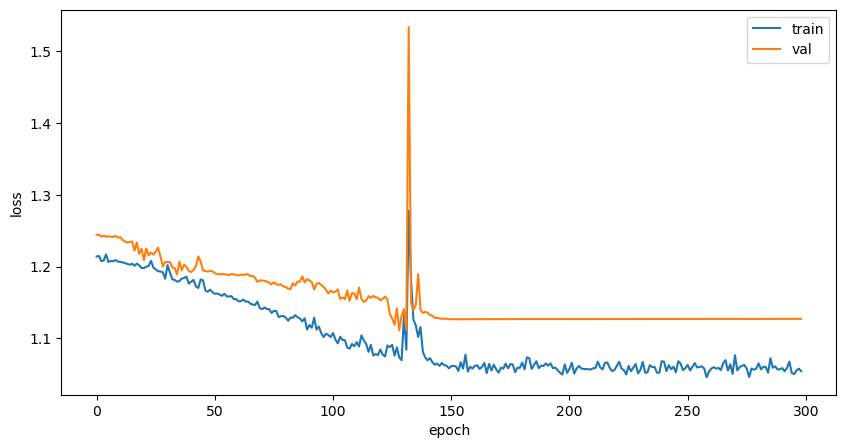

In [164]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(model.train_losses[1:], label="train")
plt.plot(model.val_losses[1:], label="val")
# plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [167]:
pred_angles = torch.cat(trainer.predict(model, test_loader))
import math

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [168]:
true_angles = []
for i in range(len(test_ds)):
    sin_cos = test_ds[i][0].y
    sin_val = sin_cos[0][0]
    cos_val = sin_cos[0][1]
    angle = torch.atan2(sin_val, cos_val)
    angle = (angle + ds.per_mean_dir) % (2 * math.pi)
    angle = angle * 180 / math.pi
    true_angles.append(angle)

true_angles = torch.tensor(true_angles)

Text(0, 0.5, 'Count')

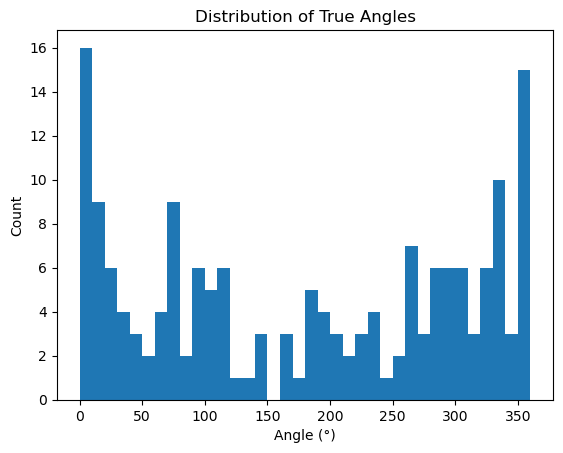

In [169]:
plt.hist(true_angles.numpy(), bins=36)
plt.title("Distribution of True Angles")
plt.xlabel("Angle (°)")
plt.ylabel("Count")


In [146]:
raw_out = model(batch, return_raw=True)  # Add hook if needed
plt.hist(raw_out.flatten().cpu().detach().numpy(), bins=100)
plt.title("Distribution of Raw Output Before Normalization")


TypeError: MultiCMPNNLitModel.forward() got an unexpected keyword argument 'return_raw'

In [170]:
pred_angles

tensor([5.5762e+01, 1.0621e+02, 3.3611e+02, 9.9435e+00, 7.6458e+01, 3.5551e+02,
        3.0686e+02, 3.5617e+02, 3.4645e+02, 6.8866e+00, 2.6152e+02, 5.4796e+01,
        3.5337e+02, 4.5305e+01, 3.0160e+02, 3.2734e+02, 3.5928e+02, 7.0899e+00,
        3.3929e+02, 3.2383e+02, 3.5692e+02, 1.6246e+02, 2.9962e+02, 2.6587e+02,
        1.2665e+02, 3.7040e+00, 3.7770e+01, 3.4978e+02, 2.2925e+01, 2.6464e+00,
        3.5339e+02, 3.0169e+01, 3.1723e+02, 3.5078e+02, 2.8485e+02, 2.9257e+01,
        5.7100e+01, 6.6698e+00, 4.6615e+01, 3.4787e+02, 3.5272e+02, 2.9529e+02,
        3.4047e+02, 7.1150e+01, 7.2396e+01, 3.5982e+02, 6.7266e+01, 4.2215e+01,
        3.4472e+02, 3.4995e+02, 3.1285e+01, 6.1498e+01, 5.0817e+01, 2.0955e+02,
        2.3825e+01, 5.8108e+01, 3.0739e+02, 1.1665e+02, 2.6277e+02, 2.8774e+02,
        4.2436e-02, 7.7442e+01, 2.5709e+01, 1.8398e+02, 7.9612e+01, 3.5564e+02,
        2.6841e+01, 1.4201e+01, 3.4710e+02, 1.8947e+02, 3.3477e+02, 6.1834e+01,
        9.8648e-01, 6.3692e+01, 8.2859e+

In [172]:
sin_vals = torch.sin(pred_angles)
cos_vals = torch.cos(pred_angles)
sin_cos = torch.stack([sin_vals, cos_vals], dim=1)  # shape (N, 2)
norms = torch.norm(sin_cos, dim=1)  # shape (N,)
print("Mean norm:", norms.mean().item(), "Min norm:", norms.min().item(), "Max norm:", norms.max().item())


Mean norm: 1.0 Min norm: 0.9999999403953552 Max norm: 1.0


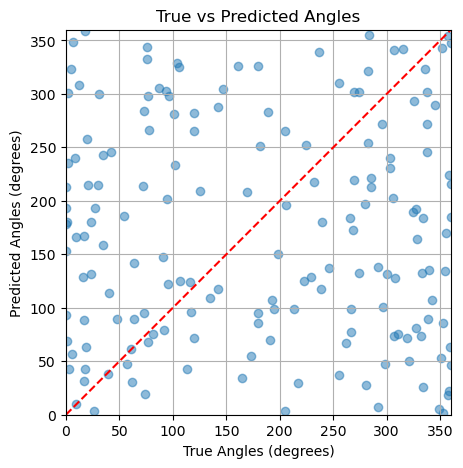

In [148]:
# Plot the residuals between true_angles and pred_angles
plt.figure(figsize=(10, 5))
plt.scatter(true_angles, pred_angles, alpha=0.5)
plt.xlabel("True Angles (degrees)")
plt.ylabel("Predicted Angles (degrees)")
plt.title("True vs Predicted Angles")
plt.plot([0, 360], [0, 360], 'r--')  # Diagonal line
plt.xlim(0, 360)
plt.ylim(0, 360)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()


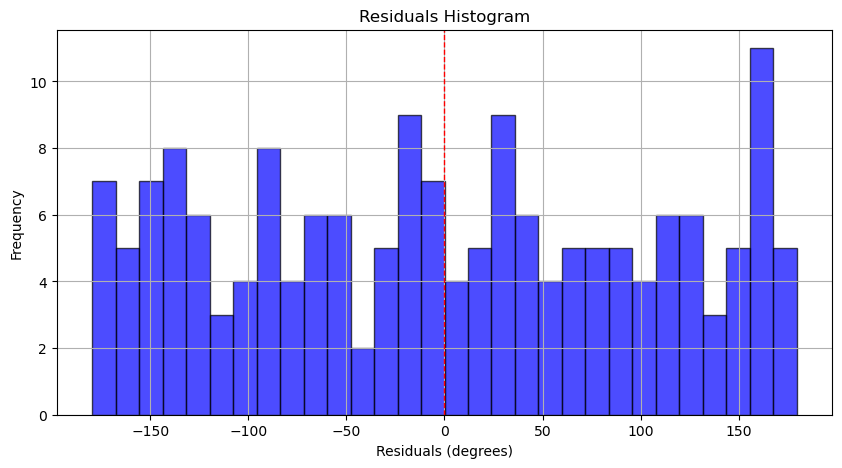

In [149]:
# Plot residuals histogram
residual = (pred_angles - true_angles + 180) % 360 - 180
plt.figure(figsize=(10, 5))
plt.hist(residual.numpy(), bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel("Residuals (degrees)")
plt.ylabel("Frequency")
plt.title("Residuals Histogram")
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=1)
plt.grid()

In [150]:
mae = residual.abs().mean()
rmse = torch.sqrt((residual ** 2).mean())
print(f"MAE: {mae.item():.2f} degrees")
print(f"RMSE: {rmse.item():.2f} degrees")

MAE: 91.01 degrees
RMSE: 106.06 degrees


In [151]:
with torch.no_grad():
    y_pred = model(batch)
    y_true = batch.y.view(batch.num_graphs // 2, 2, -1)[:, 0, :]  # shape [N, 2]
    # Recover from sin/cos
    pred_angles = torch.atan2(y_pred[:, 0], y_pred[:, 1]) + ds.per_mean_dir
    true_angles = torch.atan2(y_true[:, 0], y_true[:, 1]) + ds.per_mean_dir

    # Convert to degrees and wrap
    pred_angles_deg = (pred_angles * 180 / math.pi) % 360
    true_angles_deg = (true_angles * 180 / math.pi) % 360

    # Residual
    residuals = (pred_angles_deg - true_angles_deg + 180) % 360 - 180


In [152]:
true_angles

tensor([-2.7929e+00,  1.2247e+00, -3.1463e+00, -4.3624e-04,  2.8092e-04,
         1.7913e+00, -8.7069e-02, -3.7322e-01, -3.1640e+00, -1.0731e+00,
        -1.2155e+00,  2.4154e+00, -1.1389e+00, -8.9854e-06,  2.9397e+00,
         2.8195e+00,  1.6914e-03, -2.8186e+00,  8.3105e-01, -7.0793e-01,
         7.7469e-04, -3.0750e+00, -6.9754e-04,  1.0624e+00, -3.8576e-02,
         2.5710e-01, -1.8546e+00, -3.4452e-01,  1.4357e+00, -2.1137e-01,
        -1.5014e-04, -2.3995e+00,  3.2874e-01, -3.1410e+00, -1.0698e+00,
        -6.2812e-01,  5.5333e-01, -7.7231e-01, -1.2226e+00, -2.3475e-01,
        -8.2629e-04,  8.7196e-01, -7.2261e-01, -7.7493e-01,  2.0939e+00,
         2.4088e+00,  1.5844e+00,  5.1751e-01, -1.5121e+00,  1.8522e+00,
        -1.8395e+00, -2.5554e+00,  1.5642e+00,  1.2535e-02,  2.6926e+00,
        -1.4682e+00,  1.0128e+00,  1.3406e+00, -1.0943e-01, -3.1420e+00,
         8.1209e-02,  2.5671e-02, -9.6088e-01, -2.7137e-01])

In [ ]:
# constant baseline: always predict mean(sin), mean(cos)
import torch
y = torch.cat([batch.y.view(batch.num_graphs,2) for batch in dm.train_dataloader()])
μ = y.mean(dim=0)  # shape [2]
mse = torch.nn.MSELoss()
baseline = mse(torch.zeros_like(y)+μ, y).item()
print("Baseline MSE:", baseline)


RuntimeError: shape '[128, 2]' is invalid for input of size 128

In [ ]:
batch = next(iter(dm.train_dataloader())).to(model.device)
y_flat = batch.y.view(batch.num_graphs, -1)       # shape (2N, D)
N      = batch.num_graphs // 2
y_true = y_flat.view(N, 2, -1)[:, 0, :]           # shape (N, 2)
with torch.no_grad():
    z_all = model._encode_big_batch(batch)        # (2N, E)
z_cat = torch.cat([z_all[0::2], z_all[1::2]], dim=1).detach()  # (N, 2E)
# replace head & freeze encoders
# model.head = RawPeriodicHead(z_cat.shape[1]).to(model.device)
for enc in model.encoders:
    for p in enc.parameters():
        p.requires_grad = False

# optimizer + loss
opt = torch.optim.Adam(model.head.parameters(), lr=1e-2, weight_decay=1e-4)
mse = torch.nn.MSELoss()

# overfit loop
for step in range(800):
    opt.zero_grad()
    pred = model.head(z_cat)  # (N,2)
    loss = mse(pred, y_true)
    # add a tiny unit‐circle penalty:
    sin, cos = pred[:,0], pred[:,1]
    penalty = ((sin**2 + cos**2 - 1)**2).mean()
    (loss + 0.01*penalty).backward()
    opt.step()
    if step % 20 == 0:
        print(f"{step:03d} loss={loss.item():.4f}")


NaNs in z_all!
z1 max nan min nan
z2 max nan min nan
x[nmask1] NaNs tensor(False)
x[nmask2] NaNs tensor(False)


RuntimeError: Function 'PowBackward0' returned nan values in its 0th output.

1200

In [ ]:
for enc in model.encoders:
    for p in enc.parameters():
        p.requires_grad = True
# restore your normal head (with /norm)
from model import PeriodicHead
model.head = PeriodicHead(
    input_dim=z_cat.size(1), hidden_dim=300, n_layers=1, dropout=0.1
).to(model.device)


In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.5, patience=5)

for epoch in range(50):
    # train loop
    model.train()
    total_train = 0.0
    for batch in dm.train_dataloader():
        batch = batch.to(model.device)
        y_flat = batch.y.view(batch.num_graphs, -1)
        N      = batch.num_graphs // 2
        y_true = y_flat.view(N,2,-1)[:,0,:]
        opt.zero_grad()
        pred = model(batch)                # (N,2) normalized sin/cos
        loss = F.mse_loss(pred, y_true)
        # optional unit-circle penalty
        sin, cos = pred[:,0], pred[:,1]
        loss = loss + 0.01 * ((sin**2+cos**2-1)**2).mean()
        loss.backward()
        opt.step()
        total_train += loss.item()
    avg_train = total_train / len(dm.train_dataloader())

    # val loop
    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for batch in dm.val_dataloader():
            batch = batch.to(model.device)
            y_flat = batch.y.view(batch.num_graphs, -1)
            N      = batch.num_graphs // 2
            y_true = y_flat.view(N,2,-1)[:,0,:]
            pred   = model(batch)
            total_val += F.mse_loss(pred, y_true).item()
    avg_val = total_val / len(dm.val_dataloader())

    print(f"Epoch {epoch} train={avg_train:.4f}  val={avg_val:.4f}")
    scheduler.step(avg_val)


Epoch 0 train=0.7404  val=0.7293
Epoch 1 train=0.7244  val=0.7311
Epoch 2 train=0.7244  val=0.7322
Epoch 3 train=0.7189  val=0.7334
Epoch 4 train=0.7391  val=0.7318
Epoch 5 train=0.7200  val=0.7356
Epoch 6 train=0.7206  val=0.7369
Epoch 7 train=0.7270  val=0.7367
Epoch 8 train=0.7242  val=0.7336
Epoch 9 train=0.7178  val=0.7318
Epoch 10 train=0.7206  val=0.7345
Epoch 11 train=0.7358  val=0.7356
Epoch 12 train=0.7224  val=0.7313
Epoch 13 train=0.7216  val=0.7318
Epoch 14 train=0.7162  val=0.7321
Epoch 15 train=0.7135  val=0.7308
Epoch 16 train=0.7195  val=0.7304
Epoch 17 train=0.7246  val=0.7299
Epoch 18 train=0.7239  val=0.7313
Epoch 19 train=0.7356  val=0.7320
Epoch 20 train=0.7278  val=0.7318
Epoch 21 train=0.7212  val=0.7314
Epoch 22 train=0.7231  val=0.7319
Epoch 23 train=0.7057  val=0.7314


KeyboardInterrupt: 

In [ ]:

model.train()
model.normalize_head = False
opt = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
mse = torch.nn.MSELoss()
train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()

for epoch in range(10):
    # Training loop
    total_train_loss = 0.0
    for batch in train_dl:
        batch = batch.to(model.device)
        opt.zero_grad()
        y_pred = model(batch)                          # (N,2)
        y_flat = batch.y.view(batch.num_graphs, -1)    # (2N,D)
        N = batch.num_graphs // 2
        y_true = y_flat.view(N, 2, -1)[:, 0, :]        # (N,2)
        loss = mse(y_pred, y_true)
        loss.backward()
        opt.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_dl)
    print(f"Epoch {epoch} avg train loss = {avg_train_loss:.4f}")

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch in val_dl:
            batch = batch.to(model.device)
            y_pred = model(batch)                          # (N,2)
            y_flat = batch.y.view(batch.num_graphs, -1)    # (2N,D)
            N = batch.num_graphs // 2
            y_true = y_flat.view(N, 2, -1)[:, 0, :]        # (N,2)
            loss = mse(y_pred, y_true)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_dl)
    print(f"Epoch {epoch} avg val loss = {avg_val_loss:.4f}")
    model.train()


Epoch 0 avg train loss = 19.6981
Epoch 0 avg val loss = 0.5258
Epoch 1 avg train loss = 0.5246
Epoch 1 avg val loss = 0.6662
Epoch 2 avg train loss = 0.4998
Epoch 2 avg val loss = 0.4847
Epoch 3 avg train loss = 0.4845
Epoch 3 avg val loss = 0.4767
Epoch 4 avg train loss = 0.4806
Epoch 4 avg val loss = 0.4799
Epoch 5 avg train loss = 0.4992
Epoch 5 avg val loss = 0.5063
Epoch 6 avg train loss = 0.5035
Epoch 6 avg val loss = 0.5656
Epoch 7 avg train loss = 0.5213
Epoch 7 avg val loss = 0.5230
Epoch 8 avg train loss = 0.4986
Epoch 8 avg val loss = 0.4816
Epoch 9 avg train loss = 0.4743
Epoch 9 avg val loss = 0.5053


In [ ]:
from torch import nn
from model import PeriodicHead

# grab one batch & move to device
batch = next(iter(dm.train_dataloader())).to(model.device)
y_flat = batch.y.view(batch.num_graphs, -1)
N       = batch.num_graphs // 2
y_true  = y_flat.view(N, 2, -1)[:, 0, :]  # (N,2)

# 1) build a beefier head
z_all = model._encode_big_batch(batch)      # (2N,E)
z_cat = torch.cat([z_all[0::2], z_all[1::2]], dim=1)
embed_dim  = z_cat.shape[1]

model.head = PeriodicHead(
    input_dim=embed_dim,
    output_dim=2,
    hidden_dim=6000,
    n_layers=3,
    dropout=0.1,
    use_residual=True
).to(model.device)
# temporarily skip unit-circle divide during overfit
model.head.normalize = False  

# 2) freeze encoder, only train head
for enc in model.encoders:
    for p in enc.parameters():
        p.requires_grad = False

# 3) optimizer with a bolder LR & small weight decay
opt = torch.optim.Adam(
    list(model.head.parameters()), 
    lr=1e-2, 
    weight_decay=1e-4
)
criterion = nn.MSELoss()

# 4) overfit test on that one batch
for step in range(100):
    opt.zero_grad()
    ŷ = model(batch)   # raw sin/cos from new head
    loss = criterion(ŷ, y_true)
    loss.backward()
    opt.step()
    if step % 20 == 0:
        print(f"step {step:03d}  loss={loss.item():.6f}")


step 000  loss=0.530812
step 020  loss=28.160769
step 040  loss=4.992714
step 060  loss=2.595320
step 080  loss=15.864535


In [ ]:
import torch
from torch import nn

# 1) grab one batch
batch = next(iter(dm.train_dataloader())).to(model.device)
y_flat = batch.y.view(batch.num_graphs, -1)
N       = batch.num_graphs // 2
y_true  = y_flat.view(N, 2, -1)[:, 0, :].to(model.device)  # (N,2)

# 2) compute z_cat once
with torch.no_grad():
    z_all = model._encode_big_batch(batch)
z_cat = torch.cat([z_all[0::2], z_all[1::2]], dim=1).detach()  # (N, E*2)
embed_dim = z_cat.shape[1]

# 3) make a bare linear head
plain_head = nn.Linear(embed_dim, 2).to(model.device)
criterion = nn.MSELoss()
opt = torch.optim.Adam(plain_head.parameters(), lr=1e-2)

# 4) overfit loop
for step in range(100):
    opt.zero_grad()
    y_pred = plain_head(z_cat)
    loss   = criterion(y_pred, y_true)
    loss.backward()
    opt.step()
    if step % 20 == 0:
        print(f"step {step:03d}  loss={loss.item():.6f}")


step 000  loss=0.536796
step 020  loss=0.521324
step 040  loss=0.222786
step 060  loss=0.125554
step 080  loss=0.077855


In [ ]:
import torch
from torch import nn

# 1) grab one batch
batch = next(iter(dm.train_dataloader())).to(model.device)
y_flat = batch.y.view(batch.num_graphs, -1)
N       = batch.num_graphs // 2
y_true  = y_flat.view(N, 2, -1)[:, 0, :].to(model.device)  # (N,2)

# 2) compute z_cat once
with torch.no_grad():
    z_all = model._encode_big_batch(batch)
z_cat = torch.cat([z_all[0::2], z_all[1::2]], dim=1).detach()  # (N, E*2)
embed_dim = z_cat.shape[1]

# 3) define a tiny MLP head (no unit-circle divide)
# class TinyHead(nn.Module):
#     def __init__(self, dim):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(dim, dim//2),
#             nn.ReLU(),
#             nn.Linear(dim//2, 2),
#         )
#     def forward(self, x):
#         return self.net(x)  # raw sin/cos

# head = TinyHead(embed_dim).to(model.device)
class StablePeriodicHead(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim//2),
            nn.ReLU(),
            nn.Linear(dim//2, 2),
        )
    def forward(self, x):
        out = self.net(x)
        return out / (out.norm(dim=-1, keepdim=True) + 1e-8)

head = StablePeriodicHead(embed_dim).to(model.device)
# 4) overfit head
opt = torch.optim.Adam(head.parameters(), lr=1e-2, weight_decay=1e-4)
mse = nn.MSELoss()
for i in range(100):
    opt.zero_grad()
    pred = head(z_cat)
    loss = mse(pred, y_true)
    loss.backward()
    opt.step()
    if i % 20 == 0:
        print(f"{i:03d}  loss={loss.item():.6f}")


000  loss=0.805431
020  loss=0.587020
040  loss=0.590405
060  loss=0.574097
080  loss=0.557582


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

# 1) Tiny MLP head (no unit‐circle divide)
class RawPeriodicHead(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim//2),
            nn.ReLU(),
            nn.Linear(dim//2, 2),
        )
    def forward(self, x):
        return self.net(x)

# 2) Overfit that head on one batch
batch = next(iter(dm.train_dataloader())).to(model.device)
y_flat = batch.y.view(batch.num_graphs, -1)
N       = batch.num_graphs // 2
y_true  = y_flat.view(N, 2, -1)[:,0,:].to(model.device)

with torch.no_grad():
    z_all = model._encode_big_batch(batch)
z_cat = torch.cat([z_all[0::2], z_all[1::2]], dim=1).detach()

head = RawPeriodicHead(z_cat.size(1)).to(model.device)
opt  = torch.optim.Adam(head.parameters(), lr=1e-2, weight_decay=1e-4)
mse  = nn.MSELoss()

for i in range(100):
    opt.zero_grad()
    pred = head(z_cat)
    loss = mse(pred, y_true)
    loss.backward()
    opt.step()
    if i % 20 == 0:
        print(f"{i:03d}  loss={loss.item():.6f}")


000  loss=0.463498
020  loss=0.345534
040  loss=0.217912
060  loss=0.144752
080  loss=0.058066


In [ ]:
# right after dm.setup():
print("train / val / test sizes:", 
      len(dm.train_dataset), len(dm.val_dataset), len(dm.test_dataset))


train / val / test sizes: 1356 170 170


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1) collect a matrix Z (N×E) and targets Y (N×2)
Z_list, Y_list = [], []
for batch in dm.train_dataloader():
    batch = batch.to(model.device)
    with torch.no_grad():
        z_all = model._encode_big_batch(batch)   # (2N, E)
    z1 = z_all[0::2].cpu().numpy()              # (N, E)
    y_flat = batch.y.view(batch.num_graphs, -1) # (2N, 2)
    N = batch.num_graphs // 2
    y_true = y_flat.view(N, 2, -1)[:, 0, :].cpu().numpy()  # (N, 2)
    Z_list.append(z1)
    Y_list.append(y_true)
Z = np.vstack(Z_list)
Y = np.vstack(Y_list)

# 2) fit a simple linear regressor
lr = LinearRegression().fit(Z, Y)
Y_pred = lr.predict(Z)
print("Linear MSE on train:", mean_squared_error(Y, Y_pred))


Linear MSE on train: 0.2482360452413559


In [ ]:
model.eval()
all_embeds = []
for batch in dm.train_dataloader():
    with torch.no_grad():
        z = model._encode_big_batch(batch.to(model.device))
        # take just the *first* molecule of each pair
        z1 = z[0::2]
        all_embeds.append(z1.cpu())
all_embeds = torch.cat(all_embeds, dim=0)  # shape (num_samples, embed_dim)
print("Encoder embed std per-dim:", all_embeds.std(dim=0).mean().item())
print("Min / Max of embed norm:", all_embeds.norm(dim=1).min().item(), all_embeds.norm(dim=1).max().item())


Encoder embed std per-dim: 0.11434251070022583
Min / Max of embed norm: 3.6436684131622314 5.966187477111816


In [ ]:
import torch
from torch import nn
from model import PeriodicHead
# 1) Grab one batch and move to device
batch = next(iter(dm.train_dataloader()))
batch = batch.to(model.device)

# 2) Prepare y_true exactly as in your LightningModule
y_flat = batch.y.view(batch.num_graphs, -1)      # (2N, D)
N      = batch.num_graphs // 2
y_true = y_flat.view(N, 2, -1)[:, 0, :]          # (N,2)

# 3) Run encoder once to get z_cat
#    (we .detach() so the encoder stays frozen later)
with torch.no_grad():
    z_all = model._encode_big_batch(batch)  # (2N, E)
z1    = z_all[0::2]                        # first of each pair -> (N, E)
z2    = z_all[1::2]                        # second of each pair -> (N, E)
z_cat = torch.cat([z1, z2], dim=1)         # (N, 2E)

# 4) Build a fresh head (no unit-circle normalization)
input_dim = z_cat.shape[1]
head = PeriodicHead(
    input_dim=input_dim,
    output_dim=2,
    hidden_dim=32,
    n_layers=1,
    dropout=0.0,
    use_residual=False
).to(model.device)

# disable the divide-by-norm step
# after you construct your head:
def raw_forward(self, x):
    return self.net(x)          # <— no divide‐by‐norm

# bind it:
head.forward = raw_forward.__get__(head, type(head))
model.head   = head
# 5) Freeze encoder weights so only the head trains
for enc in model.encoders:
    for p in enc.parameters():
        p.requires_grad = False

# 6) Set up optimizer & MSE loss on raw sin/cos
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(head.parameters(), lr=1e-3, weight_decay=0)

# 7) Overfit loop on that single batch
model.train()
for step in range(200):
    optimizer.zero_grad()
    # forward through just the head—encoder outputs are baked into z_cat
    y_pred = head(z_cat)
    loss   = criterion(y_pred, y_true)
    loss.backward()
    optimizer.step()
    if step % 20 == 0:
        print(f"step {step:03d}  loss={loss.item():.6f}")


step 000  loss=0.529808
step 020  loss=0.357654
step 040  loss=0.319406
step 060  loss=0.284352
step 080  loss=0.250473
step 100  loss=0.218685
step 120  loss=0.190435
step 140  loss=0.164865
step 160  loss=0.142127
step 180  loss=0.120539


In [ ]:
class SimpleHead(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
        )
    def forward(self, x):
        return self.net(x)

head = SimpleHead(z_cat.shape[1]).to(model.device)
model.head = head
# freeze encoder as before…

opt       = torch.optim.Adam(head.parameters(), lr=1e-3)
criterion = nn.MSELoss()
for step in range(200):
    opt.zero_grad()
    y_pred = head(z_cat)
    loss   = criterion(y_pred, y_true)
    loss.backward()
    opt.step()
    if step % 20 == 0:
        print(f"step {step:03d}  loss={loss.item():.6f}")


step 000  loss=0.591795
step 020  loss=0.357691
step 040  loss=0.316110
step 060  loss=0.281011
step 080  loss=0.247454
step 100  loss=0.215135
step 120  loss=0.186938
step 140  loss=0.160373
step 160  loss=0.138598
step 180  loss=0.118414


In [ ]:

# 2) freeze nothing, but build a param group:
head_params    = list(model.head.parameters())
encoder_params = [p for enc in model.encoders for p in enc.parameters()]

optimizer = torch.optim.Adam([
    {"params": head_params,    "lr": 1e-3},
    {"params": encoder_params, "lr": 1e-5},
], weight_decay=0)

trainer = Trainer(
    max_epochs=50,
    accelerator="gpu", devices=1,
    # skip your scheduler for now
)
# 3) monkey-patch configure_optimizers to return your optimizer:
model.configure_optimizers = lambda: optimizer

trainer.fit(model, datamodule=dm)


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/torch_geometric/data/dataset.py:240: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(
/home/calvin/code/vibe_cmpnn/dataset.py:539: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  self.std  = ys.std(dim=0, unbiased=False).float().clamp(min=1e-12)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
import torch
from torch import nn
# 1) grab one batch and move it to the right device
batch = next(iter(dm.train_dataloader()))
batch = batch.to(model.device)

# 2) run your encoder to get the 2N embeddings
with torch.no_grad():
    z_all = model._encode_big_batch(batch)    # shape (2N, E)

# 3) split into z1 / z2 and cat to get z_cat
z1 = z_all[0::2]   # first of each pair
z2 = z_all[1::2]   # second of each pair
z_cat = torch.cat([z1, z2], dim=1)  # shape (N, 2E)

# 4) pull out the true sin/cos targets from batch.y
y_flat  = batch.y.view(batch.num_graphs, -1)      # (2N, D)
N       = batch.num_graphs // 2
y_true  = y_flat.view(N, 2, -1)[:, 0, :]          # (N, D)
# D here should be 2 (sin,cos)

assert z_cat.shape[0] == y_true.shape[0]
assert y_true.shape[1] == 2

# 5) build a fresh linear head + MSELoss
head_only = nn.Linear(z_cat.size(1), 2, bias=False).to(model.device)
mse       = nn.MSELoss()
opt       = torch.optim.Adam(head_only.parameters(), lr=1e-2)

# 6) overfit loop
for step in range(100):
    pred = head_only(z_cat)           # (N,2)
    loss = mse(pred, y_true)          # now both are real Tensors
    opt.zero_grad()
    loss.backward()
    opt.step()
    if step % 10 == 0:
        print(f"{step:02d}: loss = {loss.item():.6f}")


00: loss = 0.544769
10: loss = 3.470448
20: loss = 1.323049
30: loss = 0.422271
40: loss = 0.218719
50: loss = 0.166360
60: loss = 0.148849
70: loss = 0.133371
80: loss = 0.117203
90: loss = 0.106977


In [ ]:
# re-attach head and encoder to `model`
model.head = head_only
for p in model.encoders:
    for param in p.parameters():
        param.requires_grad = True

opt_all = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.)
model.train()
for step in range(100):
    big_batch = batch.to(model.device)
    pred = model(big_batch)
    loss = mse(pred, y_true)
    opt_all.zero_grad(); loss.backward(); opt_all.step()
    if step % 10 == 0:
        print(f"[full model] step {step:03d} loss={loss.item():.4f}")


[full model] step 000 loss=0.0987
[full model] step 010 loss=1.0604
[full model] step 020 loss=0.4667
[full model] step 030 loss=0.3105
[full model] step 040 loss=0.2737
[full model] step 050 loss=0.2518
[full model] step 060 loss=0.2335
[full model] step 070 loss=0.2218
[full model] step 080 loss=0.2115
[full model] step 090 loss=0.2031


In [ ]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(name, param.grad.norm().item())


encoder1.lin_node.0.weight 1.6935406165430322e-05
encoder1.lin_node.0.bias 6.365262834151508e-06
encoder1.lin_node.1.weight 2.2153367353894282e-06
encoder1.lin_node.1.bias 1.61411446697457e-06
encoder1.lin_edge.0.weight 4.369194812170463e-06
encoder1.lin_edge.0.bias 2.9578864086943213e-06
encoder1.lin_edge.1.weight 1.7656564068602165e-06
encoder1.lin_edge.1.bias 1.1567643696253072e-06
encoder1.lin_x.0.weight 2.4848761270845898e-08
encoder1.lin_x.0.bias 8.988881639027113e-09
encoder1.lin_x.1.weight 1.5950135656694897e-09
encoder1.lin_x.1.bias 1.3284546795944152e-09
encoder1.node_updates.0.weight 2.3749449610477313e-05
encoder1.node_updates.0.bias 5.412759378486953e-07
encoder1.node_updates.1.weight 2.3395825337502174e-05
encoder1.node_updates.1.bias 1.5314014945033705e-08
encoder1.node_updates.2.weight 0.0002174914989154786
encoder1.node_updates.2.bias 2.5086882571301317e-10
encoder1.edge_updates.0.weight 2.5356735932291485e-05
encoder1.edge_updates.0.bias 3.421060910113738e-07
encoder1

In [ ]:
import torch
from torch import nn

# 1) grab one batch & move it to your device
batch = next(iter(dm.train_dataloader()))
batch = batch.to(model.device)

# 2) pull out your sin/cos “ground truth” the same way you do in your LitModule:
with torch.no_grad():
    y_flat = batch.y.view(batch.num_graphs, -1)      # (2N, D)
N = batch.num_graphs // 2
y_true = y_flat.view(N, 2, -1)[:, 0, :]             # (N, D), here D==2

# 3) compute your embedding dims
with torch.no_grad():
    z_all = model._encode_big_batch(batch)          # (2N, E)
z1 = z_all[0::2]                                    # (N, E)
z2 = z_all[1::2]                                    # (N, E)
embed_dim = z1.size(1)                              # E
head_input_dim = 2 * embed_dim                      # what your head sees
# if you used `head_hidden = head_input_dim//2` in your model:
head_hidden = head_input_dim // 2                   # or just pick 300

# 4) sweep LR & weight‐decay on a fresh head, freezing the encoder
lrs = [1e-1, 1e-2, 1e-3, 1e-4]
wds = [0.0, 1e-4, 1e-3, 1e-2]

best = dict(final_loss=1e9, lr=None, wd=None)
from model import PeriodicHead
for lr in lrs:
    for wd in wds:
        # a brand‐new PeriodicHead each time
        head = PeriodicHead(
            input_dim=head_input_dim,
            hidden_dim=head_hidden,
            n_layers=2,           # give it a little depth
            dropout=0.1,
            use_residual=True
        ).to(model.device)
        model.head = head

        # freeze everything except the head
        for enc in model.encoders:
            for p in enc.parameters():
                p.requires_grad = False

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        criterion = nn.MSELoss()

        # overfit loop on this one batch
        for step in range(100):
            optimizer.zero_grad()
            y_pred = model(batch)        # (N,2)
            loss   = criterion(y_pred, y_true)
            loss.backward()
            optimizer.step()

        if loss.item() < best['final_loss']:
            best.update(final_loss=loss.item(), lr=lr, wd=wd)

print("Best on one batch:", best)


KeyboardInterrupt: 

In [ ]:
import torch
from torch import nn

# 1) Grab one batch
batch = next(iter(dm.train_dataloader()))
batch = batch.to(model.device)

# 2) Build y_true exactly as in your module
y_flat = batch.y.view(batch.num_graphs, -1)    # (2N, D)
N       = batch.num_graphs // 2
y_true  = y_flat.view(N, 2, -1)[:, 0, :]      # (N,2)

# 3) Freeze encoder and swap in a “trainable but unnormalized” head
for enc in model.encoders:
    for p in enc.parameters():
        p.requires_grad = False

model.head.normalize = False  # <— key change
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

# 4) Overfit loop
for step in range(100):
    optimizer.zero_grad()
    y_pred = model(batch)   # now head.forward() skips the unit-circle divide
    loss   = criterion(y_pred, y_true)
    loss.backward()
    optimizer.step()
    if step % 10 == 0:
        print(f"{step:02d} loss={loss.item():.4f}")


00 loss=0.7652
10 loss=0.6323
20 loss=0.6127
30 loss=0.5614
40 loss=0.5776
50 loss=0.5470
60 loss=0.4995
70 loss=0.4451
80 loss=0.3677
90 loss=0.3244


In [ ]:
from pytorch_lightning.tuner.tuning import Tuner


# create a Tuner wrapping your existing Trainer
tuner = Tuner(trainer)

# run the LR finder
lr_finder = tuner.lr_find(
    model,
    datamodule=dm,
    # optional: specify a range
    min_lr=1e-6,
    max_lr=10,
    num_training=1000,       # how many steps to run
)


/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/torch_geometric/data/dataset.py:240: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


/home/calvin/code/vibe_cmpnn/dataset.py:539: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  self.std  = ys.std(dim=0, unbiased=False).float().clamp(min=1e-12)
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory tb_logs/cmpnn/version_112/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` stopped: `max_epochs=300` reached.
LR finder stopped early after 242 steps due to diverging loss.


In [ ]:
from pytorch_lightning import Trainer

trainer = Trainer(
    max_epochs=100,           # run 100 “epochs”
    limit_train_batches=1,    # only 1 batch from the train loader each epoch
    limit_val_batches=0,      # skip validation entirely
    accelerator="gpu",
    devices=1,
)

# this uses your existing train_dataloader, but only that first batch every epoch
trainer.fit(model, datamodule=dm)


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.


/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/torch_geometric/data/dataset.py:240: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(
/home/calvin/code/vibe_cmpnn/dataset.py:539: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  self.std  = ys.std(dim=0, unbiased=False).float().clamp(min=1e-12)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params | Mode 
---------------------------------------------------
0 | encoder1  | CMPNNEncoder | 3.5 M  | train
1 | encoder2  | CMPNNEncoder | 3.5 M  | train
2 | head      | PeriodicHead | 721 K  | train
3 | metrics   | ModuleDict

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
# 1) Grab one batch
batch = next(iter(dm.train_dataloader()))

# 2) Grab your optimizer (no scheduler)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=model.weight_decay)

model.train()
for step in range(50):
    opt.zero_grad()
    # forward + loss
    loss = model.training_step(batch, 0)   # returns a Tensor
    loss.backward()
    
    # compute total gradient norm
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            total_norm += p.grad.data.norm()**2
    total_norm = total_norm**0.5

    print(f"step {step:02d}  loss={loss.item():.4f}  grad_norm={total_norm:.4f}")
    
    opt.step()


/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


step 00  loss=1.4700  grad_norm=13.0571
step 01  loss=1.5932  grad_norm=1.5689
step 02  loss=1.6042  grad_norm=1.2718
step 03  loss=1.5837  grad_norm=1.1515
step 04  loss=1.5987  grad_norm=1.0577
step 05  loss=1.5557  grad_norm=1.2467
step 06  loss=1.5695  grad_norm=1.4891
step 07  loss=1.5098  grad_norm=1.1657
step 08  loss=1.4652  grad_norm=1.5627
step 09  loss=1.4220  grad_norm=1.1377
step 10  loss=1.3434  grad_norm=1.3483
step 11  loss=1.3003  grad_norm=0.9090
step 12  loss=1.2764  grad_norm=0.8490
step 13  loss=1.2873  grad_norm=0.5649
step 14  loss=1.2756  grad_norm=0.5676
step 15  loss=1.2875  grad_norm=0.5902
step 16  loss=1.3122  grad_norm=0.5893
step 17  loss=1.2940  grad_norm=0.6657
step 18  loss=1.2726  grad_norm=0.6003
step 19  loss=1.2866  grad_norm=0.5039
step 20  loss=1.2963  grad_norm=0.5724
step 21  loss=1.3024  grad_norm=0.5607
step 22  loss=1.2861  grad_norm=0.4903
step 23  loss=1.2867  grad_norm=0.7463
step 24  loss=1.2913  grad_norm=0.5683
step 25  loss=1.2591  gr

In [ ]:
# unpack one batch
batch = next(iter(dm.train_dataloader()))
y_pred = model(batch)                            # (B, 2)
y_flat = batch.y.view(batch.num_graphs, -1)      # (2N, D)
N      = batch.num_graphs//2
y_true = y_flat.view(N, 2, -1)[:, 0, :]           # (N, D)

# compute mask of valid rows
valid = ~(y_true == model.hparams.ignore_val).any(dim=1)  # (N,)
print(f"{valid.sum().item()} valid samples out of {len(valid)} in that batch")

AttributeError: 'bool' object has no attribute 'any'

In [ ]:
import torch.nn as nn
from torch.nn import MSELoss

# stash originals
orig_head      = model.head
orig_criterion = model.criterion

# replace with linear head + MSE
head_in = orig_head.net.input_dim  # same dimensionality
model.head      = nn.Linear(head_in, 2).to(model.device)
model.criterion = MSELoss()

# overfit loop again
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
model.train()
for step in range(50):
    opt.zero_grad()
    loss = model.training_step(batch, 0)
    loss.backward()
    opt.step()
    print(f"step {step:02d}  loss={loss.item():.4f}")

# restore
model.head      = orig_head
model.criterion = orig_criterion


step 00  loss=0.5307
step 01  loss=3.2688
step 02  loss=0.6746
step 03  loss=0.6431
step 04  loss=0.8190
step 05  loss=0.6187
step 06  loss=0.4547
step 07  loss=0.5073
step 08  loss=0.5728
step 09  loss=0.5199
step 10  loss=0.4460
step 11  loss=0.4350
step 12  loss=0.4670
step 13  loss=0.4883
step 14  loss=0.4589
step 15  loss=0.4256
step 16  loss=0.4093
step 17  loss=0.4165
step 18  loss=0.4244
step 19  loss=0.4199
step 20  loss=0.4028
step 21  loss=0.3928
step 22  loss=0.3923
step 23  loss=0.3889
step 24  loss=0.3763
step 25  loss=0.3786
step 26  loss=0.3890
step 27  loss=0.3723
step 28  loss=0.3604
step 29  loss=0.3644
step 30  loss=0.3504
step 31  loss=0.3583
step 32  loss=0.3501
step 33  loss=0.3503
step 34  loss=0.3336
step 35  loss=0.3408
step 36  loss=0.3391
step 37  loss=0.3334
step 38  loss=0.3360
step 39  loss=0.3367
step 40  loss=0.3271
step 41  loss=0.3249
step 42  loss=0.3269
step 43  loss=0.3224
step 44  loss=0.3156
step 45  loss=0.3008
step 46  loss=0.3047
step 47  loss

In [ ]:
trainer.test(
    model,
    datamodule=dm,
    ckpt_path=None,
)

/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/torch_geometric/data/dataset.py:240: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(
/home/calvin/code/vibe_cmpnn/dataset.py:523: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  self.std  = ys.std(dim=0, unbiased=False).float().clamp(min=1e-12)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[DEBUG] z_graph: mean=-0.005036900285631418, std=0.5861964225769043, norm=14.244894981384277
[DEBUG] z_global: mean=-0.006732393987476826, std=0.5958136320114136, norm=14.575729370117188
[z_cat stats] -0.005884646438062191 0.5909978151321411 22.228364944458008
[DEBUG] angular_error ignoring value -10
SHAPE: torch.Size([7, 2]), torch.Size([7, 2])
SHAPE: torch.Size([7])
SHAPE: torch.Size([7])
[DEBUG LOSS] test core=0.6491, penalty=0.0000, total=0.6491


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6491351127624512     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6491351127624512}]

In [ ]:
preds = trainer.predict(model, datamodule=dm)  # list[ Tensor[N_i] ]
all_preds = torch.cat(preds, dim=0)          # Tensor[181]
print(all_preds)

/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/torch_geometric/data/dataset.py:240: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(
/home/calvin/code/vibe_cmpnn/dataset.py:523: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  self.std  = ys.std(dim=0, unbiased=False).float().clamp(min=1e-12)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[DEBUG] z_graph: mean=-0.005036898888647556, std=0.5861963629722595, norm=14.244893074035645
[DEBUG] z_global: mean=-0.006732393987476826, std=0.5958136320114136, norm=14.575729370117188
[z_cat stats] -0.005884646438062191 0.5909978151321411 22.228364944458008
tensor([353.3131, 353.4437, 353.0035, 353.6177, 354.1756, 351.9063, 352.0171,
        351.9905, 351.9977])


In [ ]:
all_preds.shape

torch.Size([181])

In [ ]:
# Collect all test_dataloader y
true_y = []
for batch in test_loader:
    # Only take every second y
    true_y.append(batch.y[::2])  # Tensor[64, 2]
true_y = torch.cat(true_y, dim=0)  # Tensor[181, 2]

In [ ]:
true_y.shape

torch.Size([181, 2])

In [ ]:

# Compute the angle (theta) from sin and cos values
true_theta = torch.where(
    true_y[..., 0] == -10, 
    torch.tensor(-10.0, device=true_y.device),  # Keep -10 as is
    torch.atan2(true_y[..., 0], true_y[..., 1])  # Compute atan2 for valid values
)

# Convert to degrees
true_deg = torch.where(
    true_theta == -10,
    torch.tensor(-10.0, device=true_theta.device),  # Keep -10 as is
    true_theta * 180.0 / torch.pi  # Convert valid radians to degrees
)

# Ensure degrees are in the range [0, 360) for valid values
true_deg = torch.where(
    true_deg == -10,
    true_deg,  # Keep -10 as is
    true_deg % 360.0  # Normalize valid degrees
)

# Set the print options to suppress scientific notation
torch.set_printoptions(sci_mode=False)
print(true_deg)

tensor([   -10.0000,    332.0890,     49.8532,     37.7229,     46.3269,
           217.7069,    299.2800,    343.3428,    340.4858,    328.5795,
           150.8692,     46.5301,     84.0576,    282.9548,    328.9590,
           218.9244,    346.9791,    119.1237,    131.3261,     65.4235,
           220.9652,     16.2020,     21.3853,    119.8216,    350.2300,
           239.8332,    179.7326,    179.9942,    357.0247,    276.2914,
           282.2538,    346.2236,     43.0225,      7.6281,     39.1450,
           236.5552,    283.5990,    204.6917,    355.4701,     40.4915,
           303.7410,    350.4498,     31.7037,    325.5664,     90.0605,
            62.1747,     18.6538,    321.3817,    339.2704,    178.1472,
           265.1026,    348.6366,    143.8015,    163.3258,    271.4944,
           313.1190,    179.9877,    -10.0000,    330.7414,    183.8454,
           180.0030,    327.8297,    331.6864,     80.6194,    135.2667,
           356.3757,      0.9040,    359.9715,    1

In [ ]:
true_deg.shape

torch.Size([181])

In [ ]:
import torch

# assume:
#   preds :  Tensor[TOTAL]  # your concatenated predictions in [0..360)
#   truth :  Tensor[TOTAL]  # your true angles, with –10 as ignore_val

ignore_val = -10.0

# 1) build a mask of all valid entries
mask = true_deg != ignore_val                # Tensor[bool]

preds     = torch.as_tensor(all_preds)
true_deg  = torch.as_tensor(true_deg)
# 2) apply it
preds_filt = preds[mask]
truth_filt = true_deg[mask]

# 3a) *naïve* MAE
mae_linear = (preds_filt - truth_filt).abs().mean()
print("Linear MAE: ", mae_linear.item())

# 3b) *circular* MAE (accounts for wrap-around at 0/360)
delta = (preds_filt - truth_filt + 180.0) % 360.0 - 180.0
mae_circ = delta.abs().mean()
print("Circular MAE:", mae_circ.item())


Linear MAE:  117.39505767822266
Circular MAE: 85.86058807373047


In [ ]:
std_true = truth_filt.std().item()
print(f"Ground‐truth angular std: {std_true:.1f}°")


Ground‐truth angular std: 121.4°


In [ ]:
# after concatenating all batch outputs:

preds_std = preds_filt.std().item()
print(f"Prediction angular std: {preds_std:.1f}°")


Prediction angular std: 27.9°


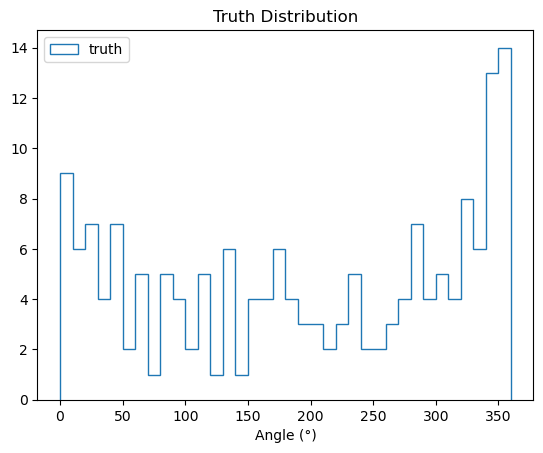

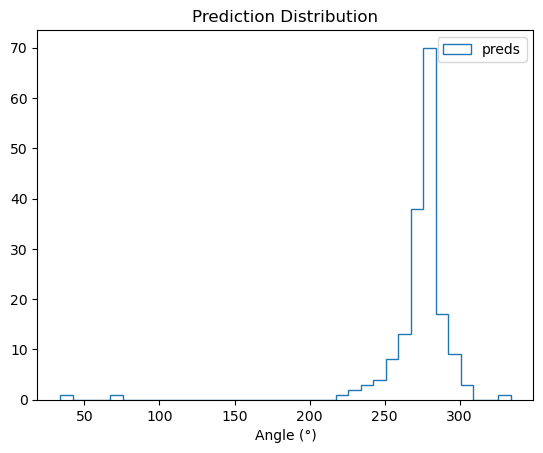

In [ ]:
import matplotlib.pyplot as plt

# 1) Truth distribution
plt.hist(truth_filt.numpy(), bins=36, histtype='step', label='truth')
plt.title("Truth Distribution")
plt.xlabel("Angle (°)")
plt.legend()
plt.show()

# 2) Prediction distribution
plt.hist(preds_filt.numpy(), bins=36, histtype='step', label='preds')
plt.title("Prediction Distribution")
plt.xlabel("Angle (°)")
plt.legend()
plt.show()
